## import

In [1]:
from simcc import *
import pycatima as catima
import numpy as np
import matplotlib.pyplot as plt

# 物質を取得する

In [2]:
material = "P10 620 Torr"

GetMaterial(material)

if len(material.split()) == 3 and material.split()[2] == "Torr":
    density_factor = float(material.split()[1]) / 760
    print(density_factor)
else:raise

0.8157894736842105


## 平均自由行程を取得する

In [3]:
Z=92
energy=345
Target="Be"
result = GetMaterial(Target)
zts, m_fractions, density, solid_gas = result["zts"], result["m_fractions"], result["density"], result["solid_gas"]
MFP = GetMFP(Z, energy, Target)

for k,v in MFP.items():
    print(k,v,"cm")
print("solid or gas:",solid_gas)
print("density",density,"g/cm3")

92->91 0.02505616928223654 cm
91->92 0.1697832310199199 cm
91->90 0.04248731954740538 cm
90->91 0.0824466567753508 cm
90->89 0.13961700511580422 cm
89->90 0.012005426398589475 cm
89->88 0.16127758500349887 cm
88->89 0.006163809633206862 cm
88->87 0.18826335533005328 cm
87->88 0.004016819701494152 cm
87->86 0.22241586942110173 cm
86->87 0.002911672892540588 cm
solid or gas: solid
density 1.848 g/cm3


## 平衡電荷を計算する

In [4]:
print(GetAnalyticalEqProb(MFP))
print(GetAnalyticalEqCharge(MFP))

[0.04524897571162054, 0.3066118052653524, 0.5949803033297486, 0.051161334067515905, 0.0019553165045609255, 4.1718973107684834e-05, 5.461480937418714e-07]
90.34191044810024


## 電荷状態の履歴をMCで計算する

In [5]:
rs = np.random.RandomState(1)
histories = GetMCHistories(MFP, 92, 0.3, random_state = rs)
histories = GetMCHistories(MFP, 92, 0.3, random_state = rs, histories = histories)


## 電荷状態を取得する

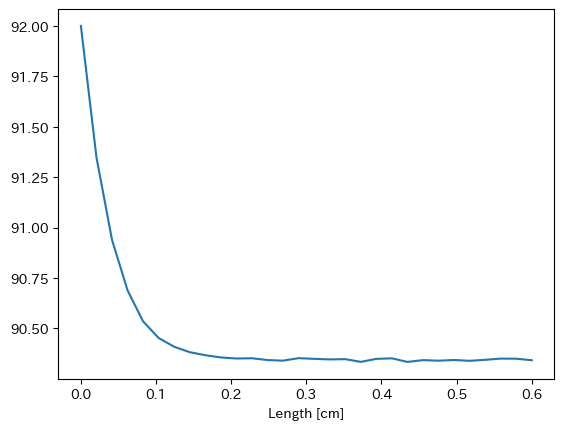

In [6]:
Charges = []
lengths = np.linspace(0,0.6,30)
for length in lengths:
    Charges.append(np.mean(GetMCProbImpl(histories,length)))
    
import matplotlib.pyplot as plt
plt.plot(lengths, Charges)
plt.xlabel("Length [cm]")
plt.show()

## 電荷変化回数を取得する

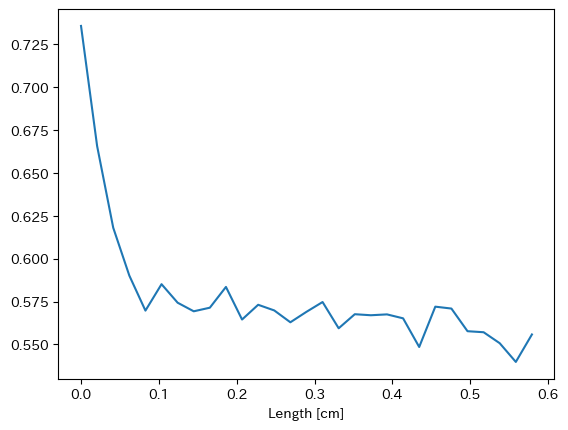

In [7]:
Nccs = []
for length in lengths[:-1]:
    Nccs.append(np.mean(GetMCNcc(histories,length,length+lengths[1]-lengths[0])))
    
plt.plot(lengths[:-1], Nccs)
plt.xlabel("Length [cm]")
plt.show()

## ある区間の平均電荷を取得する

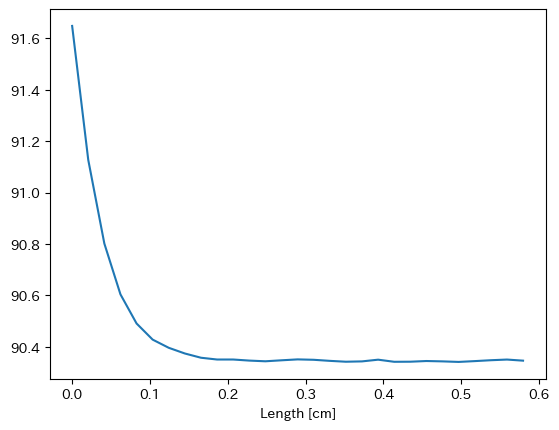

In [8]:
MeanCharges = []
for length in lengths[:-1]:
    MeanCharges.append(np.mean(GetMCMeanCharge(histories,length,length+lengths[1]-lengths[0])))
    
import matplotlib.pyplot as plt
plt.plot(lengths[:-1], MeanCharges)
plt.xlabel("Length [cm]")
plt.show()

## ある区間の各電荷状態の存在確率を取得する

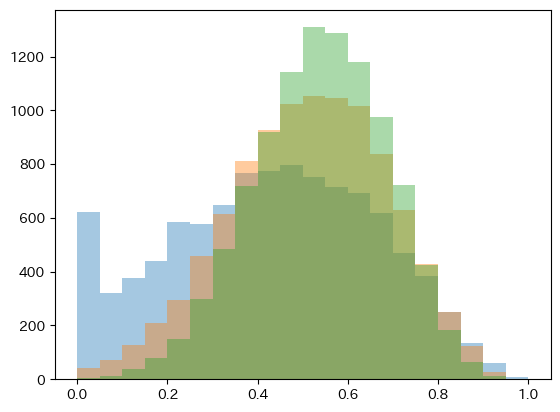

In [9]:
lengths2 = np.linspace(0,0.6,4)[1:]

for length in lengths2:
    ChargeProbabilities = GetMCMeanProb(histories, 0, length)
    plt.hist(ChargeProbabilities[Z-2],bins=20,range=[0,1],alpha=0.4)
plt.show()

## 電荷状態を考慮したエネルギーロスを計算

345.000 -> 327.008 MeV/u
GetMCHistories ....Elapsed time 0.2 s
GetMCDeltaE ....Elapsed time 0.1 s
345.000 -> 326.945 MeV/u
GetMCProbImpl .....................Elapsed time 0.2 s


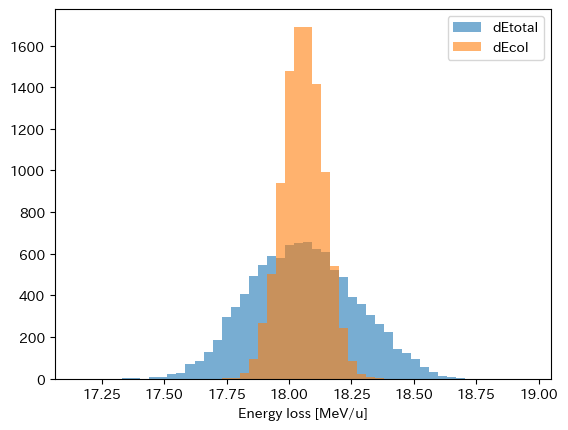

In [11]:
A,Q=238,Z

dEtotal, dEcol, dEcc, charges,histories = GetDeltaE(A,Z,Q,energy,Target,0.1)
histRange = [np.mean(dEtotal)*0.95,np.mean(dEtotal)*1.05]
plt.hist(dEtotal,bins=50,range=histRange,alpha=0.6,label="dEtotal")
plt.hist(dEcol,bins=50,range=histRange,alpha=0.6,label="dEcol")
plt.xlabel("Energy loss [MeV/u]")
plt.legend()
plt.show()